In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.modflow.types.discretization import SpatialDiscretization
from morpheus.modflow.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.modflow.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, nx=100, ny=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.modflow.types.discretization.time.TimeUnit import TimeUnit
from morpheus.modflow.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.modflow.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Modflow Model

In [4]:
from morpheus.modflow.types.ModflowModel import ModflowModel

modflow_model = ModflowModel.new()
modflow_model = modflow_model.with_updated_time_discretization(time_discretization)
modflow_model = modflow_model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup constant head boundary with two observations

In [6]:
from morpheus.modflow.types.boundaries.GeneralHeadObservation import ObservationId, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.modflow.types.geometry import Point
from morpheus.modflow.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.modflow.types.soil_model import LayerId
from morpheus.modflow.types.boundaries.Boundary import GeneralHeadBoundary

layers_list = [LayerId.new()]

general_head_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[modflow_model.soil_model.layers[0].id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.966)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.964)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(200),
          conductance=Conductance.from_float(200),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(200),
          conductance=Conductance.from_float(200),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[modflow_model.soil_model.layers[0].id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96599)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(300),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(300),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96401)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(400),
          conductance=Conductance.from_float(400),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(400),
          conductance=Conductance.from_float(400),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(general_head_east)

modflow_model = modflow_model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(general_head_east.as_geojson()))
m.add_child(folium.GeoJson(general_head_east.affected_cells.as_geojson(grid).as_geojson()))
for observation in general_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.as_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [7]:
general_head_east.observations

[GeneralHeadObservation(observation_id=ObservationId(value='9c0700e4-6283-4d01-97bb-81e7e8cd4de1'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), raw_data=[GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0)), stage=Stage(value=100), conductance=Conductance(value=100)), GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0)), stage=Stage(value=100), conductance=Conductance(value=100))]),
 GeneralHeadObservation(observation_id=ObservationId(value='a58c8e35-e58b-4374-aaa7-16487a032458'), geometry=Point(coordinates=(13.92499, 50.964), type='Point'), raw_data=[GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0)), stage=Stage(value=200), conductance=Conductance(value=200)), GeneralHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0)), stage=Stage(value=200), conductance=Conductance(value=200))])]

In [8]:
from morpheus.modflow.infrastructure.calculation.engines.modflow_2005.packages.GhbPackageMapper import \
  calculate_ghb_boundary_stress_period_data

result = calculate_ghb_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  soil_model=modflow_model.soil_model,
  ghb_boundary=general_head_west,
)
result.to_dict()

{0: [[0, 0, 0, 300.5050289789967, 300.5050289789967],
  [0, 1, 0, 302.5251892522284, 302.5251892522284],
  [0, 2, 0, 304.54535126413674, 304.54535126413674],
  [0, 3, 0, 306.5655150157982, 306.5655150157982],
  [0, 4, 0, 308.5856805068539, 308.5856805068539],
  [0, 5, 0, 310.60584773730386, 310.60584773730386],
  [0, 6, 0, 312.62601670750695, 312.62601670750695],
  [0, 7, 0, 314.6461874167454, 314.6461874167454],
  [0, 8, 0, 316.66635986573704, 316.66635986573704],
  [0, 9, 0, 318.68653405412294, 318.68653405412294],
  [0, 10, 0, 320.70670998226194, 320.70670998226194],
  [0, 11, 0, 322.72688764979523, 322.72688764979523],
  [0, 12, 0, 324.7470670563639, 324.7470670563639],
  [0, 13, 0, 326.7672482030445, 326.7672482030445],
  [0, 14, 0, 328.7874310884017, 328.7874310884017],
  [0, 15, 0, 330.80761571422977, 330.80761571422977],
  [0, 16, 0, 332.8278020790932, 332.8278020790932],
  [0, 17, 0, 334.847990182992, 334.847990182992],
  [0, 18, 0, 336.8681800270029, 336.8681800270029],
  [0,

In [9]:
from morpheus.modflow.infrastructure.calculation.engines.modflow_2005.packages.GhbPackageMapper import \
  calculate_ghb_boundary_stress_period_data

result = calculate_ghb_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  soil_model=modflow_model.soil_model,
  ghb_boundary=general_head_east,
)
result.to_dict()

{0: [[0, 0, 99, 100.99997868936319, 100.99997868936319],
  [0, 1, 99, 102.99993735985626, 102.99993735985626],
  [0, 2, 99, 104.99989775163911, 104.99989775163911],
  [0, 3, 99, 106.99985986577755, 106.99985986577755],
  [0, 4, 99, 108.99982370191631, 108.99982370191631],
  [0, 5, 99, 110.9997892600554, 110.9997892600554],
  [0, 6, 99, 112.99975654055007, 112.99975654055007],
  [0, 7, 99, 114.99972554268979, 114.99972554268979],
  [0, 8, 99, 116.9996962671851, 116.9996962671851],
  [0, 9, 99, 118.99966871368073, 118.99966871368073],
  [0, 10, 99, 120.99964288253196, 120.99964288253196],
  [0, 11, 99, 122.9996187733835, 122.9996187733835],
  [0, 12, 99, 124.9995963858801, 124.9995963858801],
  [0, 13, 99, 126.99957572108755, 126.99957572108755],
  [0, 14, 99, 128.9995567775848, 128.9995567775848],
  [0, 15, 99, 130.99953955714815, 130.99953955714815],
  [0, 16, 99, 132.99952405835657, 132.99952405835657],
  [0, 17, 99, 134.99951028121004, 134.99951028121004],
  [0, 18, 99, 136.999498226

## Calculate

In [10]:
from morpheus.modflow.types.calculation.CalculationProfile import CalculationProfile, CalculationType
from morpheus.modflow.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationType.MF2005)
calculation = Calculation.new(modflow_model=modflow_model, calculation_profile=calculation_profile)

In [11]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='b19c3719-2219-4cf9-8f22-478da07af21b')

In [12]:
from morpheus.modflow.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

FloPy is using the following executable to run the model: ../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: 87edffd9-22c9-4018-bd99-9c3485715b0f.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/19 12:34:58

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/19 12:34:58
 Elapsed run time:  0.022 Seconds

  Normal termination of simulation


In [13]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['87edffd9-22c9-4018-bd99-9c3485715b0f.list', '87edffd9-22c9-4018-bd99-9c3485715b0f.ghb', '87edffd9-22c9-4018-bd99-9c3485715b0f.dis', '87edffd9-22c9-4018-bd99-9c3485715b0f.oc', '87edffd9-22c9-4018-bd99-9c3485715b0f.nam', '87edffd9-22c9-4018-bd99-9c3485715b0f.bas', '87edffd9-22c9-4018-bd99-9c3485715b0f.lpf', '87edffd9-22c9-4018-bd99-9c3485715b0f.pcg', '87edffd9-22c9-4018-bd99-9c3485715b0f.hds'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [14]:
head = calculation_service.read_head(0, 0)

In [15]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[300.51800537109375, 302.4150085449219, 303.6080017089844, 304.34698486328125, 304.7619934082031, 304.9309997558594, 304.9010009765625, 304.7049865722656, 304.3680114746094, 303.9070129394531, 303.3370056152344, 302.66900634765625, 301.9129943847656, 301.07598876953125, 300.1659851074219, 299.18798828125, 298.1470031738281, 297.0480041503906, 295.8940124511719, 294.69000244140625, 293.43701171875, 292.1400146484375, 290.8009948730469, 289.4209899902344, 288.0039978027344, 286.5509948730469, 285.0639953613281, 283.54400634765625, 281.9939880371094, 280.41400146484375, 278.80499267578125, 277.1700134277344, 275.5090026855469, 273.822998046875, 272.1130065917969, 270.3800048828125, 268.625, 266.8479919433594, 265.04998779296875, 263.23199462890625, 261.3940124511719, 259.5360107421875, 257.6600036621094, 255.76499938964844, 253.8520050048828, 251.92100524902344, 249.9720001220703, 248.00599670410156, 246.02200317382812, 244.02200317382812, 242.0030059814453, 239.96800231933594, 237.9160

In [16]:
calculation_service.read_drawdown(0, 0)

[]

In [17]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 51283.92,
 'TOTAL_IN': 51283.92,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -51283.914,
 'TOTAL_OUT': -51283.914,
 'IN-OUT': 0.0078125,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [18]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 140.5039,
 'TOTAL_IN': 140.5039,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -140.5039,
 'TOTAL_OUT': -140.5039,
 'IN-OUT': 1.5259e-05,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [19]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['87edffd9-22c9-4018-bd99-9c3485715b0f.list', '87edffd9-22c9-4018-bd99-9c3485715b0f.ghb', '87edffd9-22c9-4018-bd99-9c3485715b0f.dis', '87edffd9-22c9-4018-bd99-9c3485715b0f.oc', '87edffd9-22c9-4018-bd99-9c3485715b0f.nam', '87edffd9-22c9-4018-bd99-9c3485715b0f.bas', '87edffd9-22c9-4018-bd99-9c3485715b0f.lpf', '87edffd9-22c9-4018-bd99-9c3485715b0f.pcg', '87edffd9-22c9-4018-bd99-9c3485715b0f.hds'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

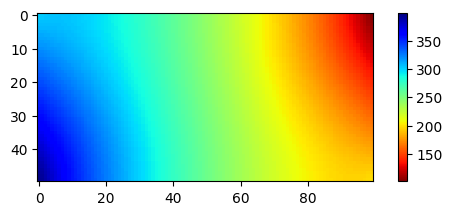

In [20]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()